In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sherpa
import sherpa.algorithms.bayesian_optimization as bayesian_optimization
import GPyOpt
import scipy
%matplotlib inline

In [2]:
def f(x, sd=0):
    y = (x-3)**2 + 10.
    if sd == 0:
        return y
    else:
        return y + np.random.normal(loc=0., scale=sd, size=np.array(x).shape)

In [247]:
signal = np.var(f(np.linspace(1, 6, 2500)))
noise = 0.1
signal/noise

55.62781222488018

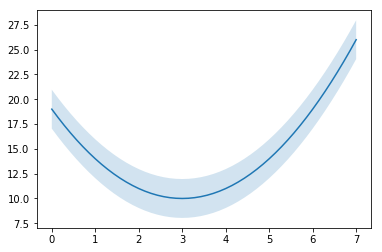

In [3]:
x = np.linspace(0, 7, 50, endpoint=True)
fig, ax = plt.subplots()
ax.plot(x, f(x))
ax.fill_between(x, f(x)-1.96*1, f(x)+1.96*1, alpha=0.2)

# GPyOpt with n=1 (no noise)

In [4]:
bounds = [{'name': 'x', 'type': 'continuous', 'domain': (1,6)}]

In [5]:
myBopt = GPyOpt.methods.BayesianOptimization(f=lambda x: f(x, sd=0),            # function to optimize       
                                             domain=bounds,        # box-constraints of the problem
                                             acquisition_type='EI',
                                             exact_feval = False)

In [6]:
# Run the optimization
max_iter = 100     # evaluation budget
max_time = 60     # time budget 
eps      = 10e-6  # Minimum allows distance between the las two observations

myBopt.run_optimization(max_iter, max_time, eps) 

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


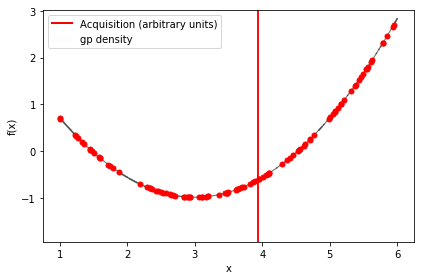

In [7]:
myBopt.plot_acquisition()

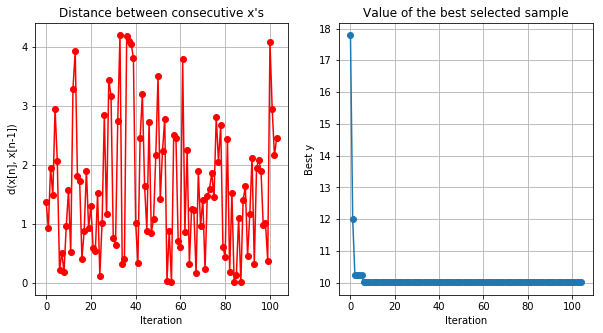

In [8]:
myBopt.plot_convergence()

In [9]:
X, Y = myBopt.get_evaluations()
print(X[np.argmin(Y)])

[3.06566026]


In [10]:
Ymean, Yvar = myBopt.model.model.predict(X)
idx = np.argmin(Ymean)
print("X=", X[idx], " Y=", Ymean[idx])

X= [3.06566026]  Y= [-0.97775102]


# GPyOpt with n=1 (sd=1)

In [248]:
bounds = [{'name': 'x', 'type': 'continuous', 'domain': (1,6)}]

In [249]:
f(3, sd=1)

9.35361888683141

In [250]:
myBopt = GPyOpt.methods.BayesianOptimization(f=lambda x: f(x, sd=0.3),            # function to optimize       
                                             domain=bounds,        # box-constraints of the problem
                                             acquisition_type='EI',
                                             exact_feval = False)

In [251]:
# Run the optimization
max_iter = 50     # evaluation budget
max_time = 60     # time budget 
eps      = 10e-6  # Minimum allows distance between the las two observations

myBopt.run_optimization(max_iter, max_time, eps) 

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


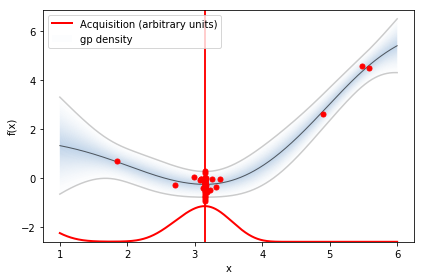

In [252]:
myBopt.plot_acquisition()

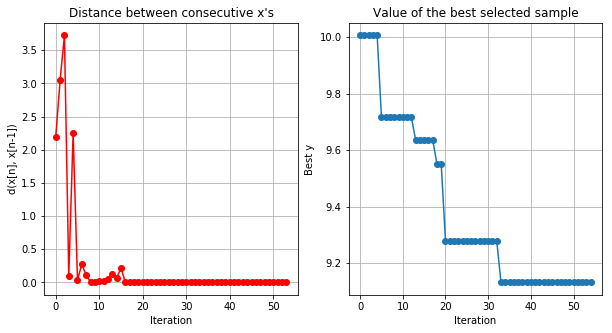

In [253]:
myBopt.plot_convergence()

In [254]:
X, Y = myBopt.get_evaluations()
print(X[np.argmin(Y)])

[3.14603064]


In [255]:
Ymean, Yvar = myBopt.model.model.predict(X)
idx = np.argmin(Ymean)
print("X=", X[idx][0], " Y=", Ymean[idx])

X= 3.1480316173499956  Y= [-0.24764523]


### Run multiple times max_iter=100

In [137]:
max_iter = 50     # evaluation budget
max_time = 60     # time budget 
eps      = 10e-6  # Minimum allows distance between the las two observations

num_runs = 100

mineval = []
minpredicted = []

for _ in range(num_runs):
    myBopt = GPyOpt.methods.BayesianOptimization(f=lambda x: f(x, sd=1),            # function to optimize       
                                                 domain=bounds,        # box-constraints of the problem
                                                 acquisition_type='EI',
                                                 exact_feval = False)
    myBopt.run_optimization(max_iter, max_time, eps) 
    X, Y = myBopt.get_evaluations()
    mineval.append(X[np.argmin(Y)][0])
    Ymean, Yvar = myBopt.model.model.predict(X)
    idx = np.argmin(Ymean)
    minpredicted.append(X[idx][0])

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


KeyboardInterrupt caught, calling on_optimization_end() to round things up


KeyboardInterrupt: 

In [ ]:
np.savez('gpyopt_max_iter_50_sd_1.npz', mineval=np.array(mineval), minpredicted=np.array(minpredicted))

In [111]:
rsmin = []
for _ in range(num_runs):
    candidates = np.random.uniform(low=1., high=6., size=max_iter)
    y = f(candidates, sd=1)
    rsmin.append(candidates[np.argmin(y)])

In [112]:
n = 5
rsmulti = []
for _ in range(num_runs):
    candidates = np.random.uniform(low=1., high=6., size=max_iter//3)
    yall = np.vstack([f(candidates, sd=1) for i in range(n)])
    ymean = np.mean(yall, axis=0)
    rsmulti.append(candidates[np.argmin(ymean)])

In [132]:
n = 5
gridmulti = []
for _ in range(num_runs):
    candidates = np.linspace(start=1., stop=6., num=max_iter//n)
    yall = np.vstack([f(candidates, sd=1) for i in range(n)])
    ymean = np.mean(yall, axis=0)
    gridmulti.append(candidates[np.argmin(ymean)])

DescribeResult(nobs=100, minmax=(2.0, 4.0), mean=3.0566666666666666, variance=0.18194163860830523, skewness=-0.058949900571425885, kurtosis=-0.48443992148586945)

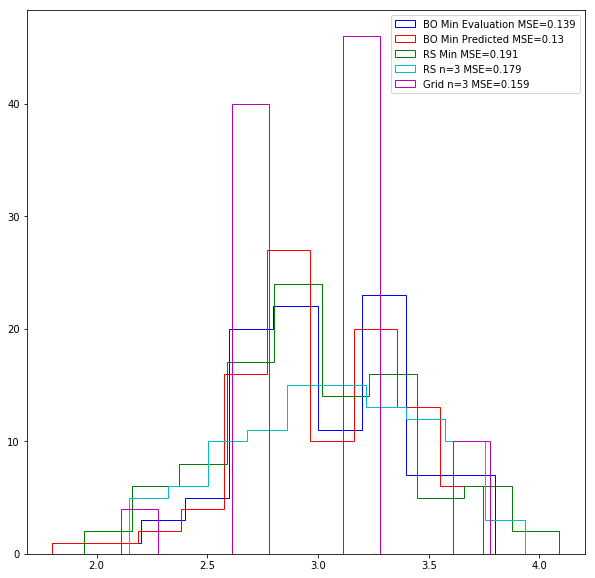

In [135]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(mineval, histtype='step', color='b', label='BO Min Evaluation MSE={:.3}'.format(np.mean((np.array(mineval)-3)**2)))
ax.hist(minpredicted, histtype='step', color='r', label='BO Min Predicted MSE={:.3}'.format(np.mean((np.array(minpredicted)-3)**2)))
ax.hist(rsmin, histtype='step', color='g', label='RS Min MSE={:.3}'.format(np.mean((np.array(rsmin)-3)**2)))
ax.hist(rsmulti, histtype='step', color='c', label='RS n=3 MSE={:.3}'.format(np.mean((np.array(rsmulti)-3)**2)))
ax.hist(gridmulti, histtype='step', color='m', label='Grid n=3 MSE={:.3}'.format(np.mean((np.array(gridmulti)-3)**2)))
ax.legend()

### Run multiple times max_iter=100

In [138]:
# max_iter = 100     # evaluation budget
# max_time = 60     # time budget 
# eps      = 10e-6  # Minimum allows distance between the las two observations

# num_runs = 100

# mineval = []
# minpredicted = []

# for _ in range(num_runs):
#     myBopt = GPyOpt.methods.BayesianOptimization(f=lambda x: f(x, sd=1),            # function to optimize       
#                                                  domain=bounds,        # box-constraints of the problem
#                                                  acquisition_type='EI',
#                                                  exact_feval = False)
#     myBopt.run_optimization(max_iter, max_time, eps) 
#     X, Y = myBopt.get_evaluations()
#     mineval.append(X[np.argmin(Y)][0])
#     Ymean, Yvar = myBopt.model.model.predict(X)
#     idx = np.argmin(Ymean)
#     minpredicted.append(X[idx][0])
# np.savez('gpyopt_max_iter_100_sd_1.npz', mineval=np.array(mineval), minpredicted=np.array(minpredicted))

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as par

INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initial

In [153]:
data = np.load('gpyopt_max_iter_100_sd_1.npz',)
mineval_100 = data['mineval']
minpredicted_100 = data['minpredicted']

In [158]:
rsmin_100 = []
for _ in range(num_runs):
    candidates = np.random.uniform(low=1., high=6., size=max_iter)
    y = f(candidates, sd=1)
    rsmin_100.append(candidates[np.argmin(y)])
rsmin_100 = np.array(rsmin_100)

In [174]:
n_rs_100 = 5
rsmulti_100 = []
for _ in range(num_runs):
    candidates = np.random.uniform(low=1., high=6., size=max_iter//n_rs_100)
    yall = np.vstack([f(candidates, sd=1) for i in range(n_rs_100)])
    ymean = np.mean(yall, axis=0)
    rsmulti_100.append(candidates[np.argmin(ymean)])
rsmulti_100 = np.array(rsmulti_100)

In [183]:
n_grid_100 = 10
gridmulti_100 = []
for _ in range(num_runs):
    candidates = np.linspace(start=1., stop=6., num=max_iter//n_grid_100)
    yall = np.vstack([f(candidates, sd=1) for i in range(n_grid_100)])
    ymean = np.mean(yall, axis=0)
    gridmulti_100.append(candidates[np.argmin(ymean)])
gridmulti_100 = np.array(gridmulti_100)

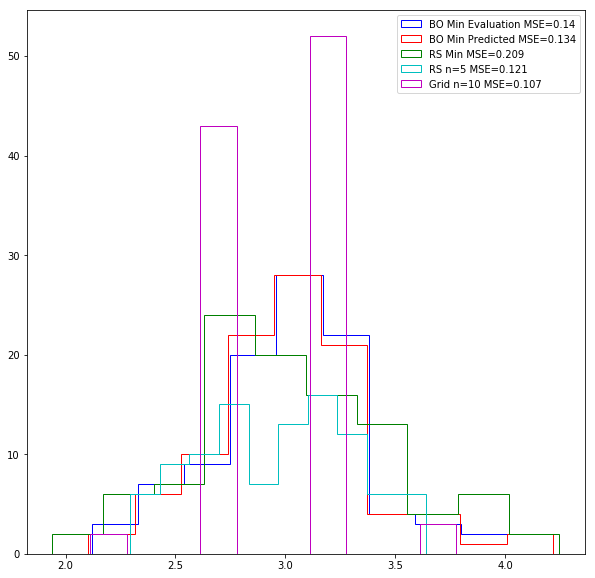

In [184]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(mineval_100, histtype='step', color='b', label='BO Min Evaluation MSE={:.3}'.format(np.mean((mineval_100-3)**2)))
ax.hist(minpredicted_100, histtype='step', color='r', label='BO Min Predicted MSE={:.3}'.format(np.mean((minpredicted_100-3)**2)))
ax.hist(rsmin_100, histtype='step', color='g', label='RS Min MSE={:.3}'.format(np.mean((rsmin_100-3)**2)))
ax.hist(rsmulti_100, histtype='step', color='c', label='RS n={} MSE={:.3}'.format(n_rs_100, np.mean((rsmulti_100-3)**2)))
ax.hist(gridmulti_100, histtype='step', color='m', label='Grid n={} MSE={:.3}'.format(n_grid_100, np.mean((gridmulti_100-3)**2)))
ax.legend()

# GPyOpt with n=5

In [185]:
bounds = [{'name': 'x', 'type': 'continuous', 'domain': (1,6)}]

In [186]:
foo = lambda x: np.mean([f(x, sd=1) for _ in range(50)])

In [225]:
myBopt = GPyOpt.methods.BayesianOptimization(f=lambda x: np.mean([f(x, sd=1) for _ in range(10)]),            # function to optimize       
                                             domain=bounds,        # box-constraints of the problem
                                             acquisition_type='EI',
                                             exact_feval = False)

In [231]:
# Run the optimization
max_iter = 10     # evaluation budget
max_time = 60     # time budget 
eps      = 10e-6  # Minimum allows distance between the las two observations

myBopt.run_optimization(max_iter, max_time, eps) 

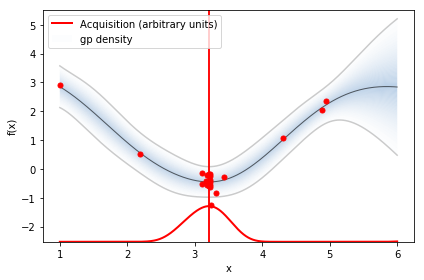

In [232]:
myBopt.plot_acquisition()

In [234]:
X, Y = myBopt.get_evaluations()
print(X[np.argmin(Y)])

[3.23577484]


In [235]:
Ymean, Yvar = myBopt.model.model.predict(X)
idx = np.argmin(Ymean)
print("X=", X[idx], " Y=", Ymean[idx])

X= [3.20959648]  Y= [-0.44804635]


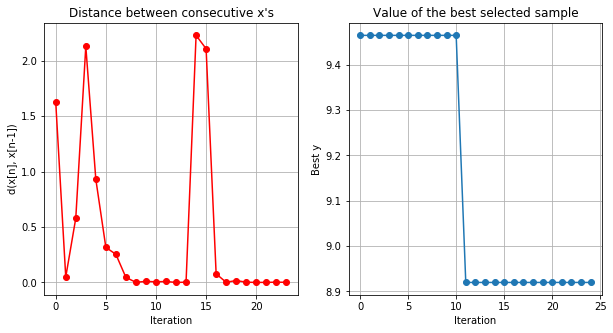

In [236]:
myBopt.plot_convergence()

### Run multiple times with max_iter=20

In [240]:
# max_iter = 20     # evaluation budget
# max_time = 60     # time budget 
# eps      = 10e-6  # Minimum allows distance between the las two observations

# num_runs = 100

# mineval = []
# minpredicted = []

# for _ in range(num_runs):
#     myBopt = GPyOpt.methods.BayesianOptimization(f=lambda x: np.mean([f(x, sd=1) for _ in range(10)]),            # function to optimize       
#                                                  domain=bounds,        # box-constraints of the problem
#                                                  acquisition_type='EI',
#                                                  exact_feval = False)
#     myBopt.run_optimization(max_iter, max_time, eps) 
#     X, Y = myBopt.get_evaluations()
#     mineval.append(X[np.argmin(Y)][0])
#     Ymean, Yvar = myBopt.model.model.predict(X)
#     idx = np.argmin(Ymean)
#     minpredicted.append(X[idx][0])
# np.savez('gpyopt_max_iter_20_n_10_sd_1.npz', mineval=np.array(mineval), minpredicted=np.array(minpredicted))

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as par

INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:GP:initial

In [241]:
data = np.load('gpyopt_max_iter_20_n_10_sd_1.npz')
mineval_n10 = data['mineval']
minpredicted_n10 = data['minpredicted']

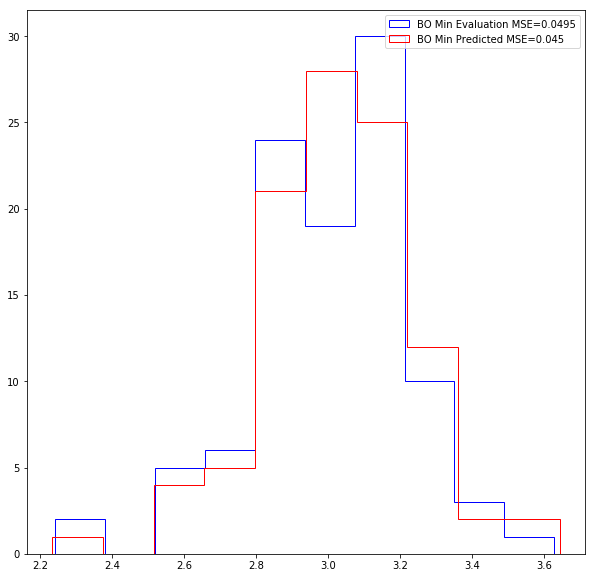

In [242]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(mineval_n10, histtype='step', color='b', label='BO Min Evaluation MSE={:.3}'.format(np.mean((mineval_n10-3)**2)))
ax.hist(minpredicted_n10, histtype='step', color='r', label='BO Min Predicted MSE={:.3}'.format(np.mean((minpredicted_n10-3)**2)))
ax.legend()